# adult dataset 

In [1]:
# Imports
import numpy as np
import pandas as pd

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval import (
    AME,
    DVRL,
    BetaShapley,
    DataBanzhaf,
    DataOob,
    DataShapley,
    InfluenceFunctionEval,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)

from opendataval.experiment import ExperimentMediator

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


## [Step 1] Set up an environment
`ExperimentMediator` is a fundamental concept in establishing the `opendataval` environment. It empowers users to configure hyperparameters, including a dataset, a type of synthetic noise, and a prediction model. With  `ExperimentMediator`, users can effortlessly compute various data valuation algorithms.

The following code cell demonstrates how to set up `ExperimentMediator` with a pre-registered dataset and a prediction model.
- Dataset: adult
- Model: sklearn's logistic regression model
- Metric: Classification accuracy

In [2]:
dataset_name = "adult"
train_count, valid_count, test_count = 100, 50, 50
noise_rate = 0.1
noise_kwargs = {'noise_rate': noise_rate}
model_name = "sklogreg"
metric_name = "accuracy"

exper_med = ExperimentMediator.model_factory_setup(
    dataset_name=dataset_name,
    cache_dir="../data_files/",  
    force_download=False,
    train_count=train_count,
    valid_count=valid_count,
    test_count=test_count,
    add_noise=mix_labels,
    noise_kwargs=noise_kwargs,
    train_kwargs={},
    model_name=model_name,
    metric_name=metric_name
)

Base line model metric_name='accuracy': perf=0.8399999737739563


A full list of registered datasets can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/dataloader/fetcher.py#L121). A list of available  prediction models can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/model/__init__.py#L111).

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [3]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceFunctionEval(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
    DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Data-Shapley
    BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Beta-Shapley
    DataBanzhaf(num_models=1000), # Data-Banzhaf
    AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000), # Data-OOB
    LavaEvaluator(),
    RobustVolumeShapley(mc_epochs=300)
]

In [4]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.000345


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 227.68it/s]


Elapsed time LeaveOneOut(): 0:00:00.449785


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 260.29it/s]


Elapsed time InfluenceFunctionEval(num_models=1000): 0:00:03.846045


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 196.78it/s]


Elapsed time DVRL(rl_epochs=2000): 0:00:10.185372


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 13409.42it/s]

Elapsed time KNNShapley(k_neighbors=50): 0:00:00.014157
Start: marginal contribution computation



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.37it/s]


gr_stat=100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.77it/s]


gr_stat=100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.54it/s]

gr_stat=1.0278980459501683
Done: marginal contribution computation


Elapsed time DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached): 0:00:07.794274
Elapsed time BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached): 0:00:00.000298


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.27it/s]


Elapsed time DataBanzhaf(num_models=1000): 0:00:03.404341


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 251.33it/s]


Elapsed time AME(num_models=1000): 0:00:13.400749


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 231.25it/s]


Elapsed time DataOob(num_models=1000): 0:00:04.329211


Elapsed time LavaEvaluator(): 0:00:00.034539


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 58.35it/s]

Elapsed time RobustVolumeShapley(mc_epochs=300): 0:00:05.145178
CPU times: user 47.6 s, sys: 499 ms, total: 48.1 s
Wall time: 48.6 s


## [Step 3] Evaluate data values

In [5]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/adult_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: mislabeled data

In [6]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
AME(num_models=1000),0.571429
"BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached)",0.461538
DVRL(rl_epochs=2000),0.432432
DataBanzhaf(num_models=1000),0.384615
DataOob(num_models=1000),0.358974
"DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached)",0.461538
InfluenceFunctionEval(num_models=1000),0.256410
KNNShapley(k_neighbors=50),0.486486
LavaEvaluator(),0.176471
LeaveOneOut(),0.107527


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

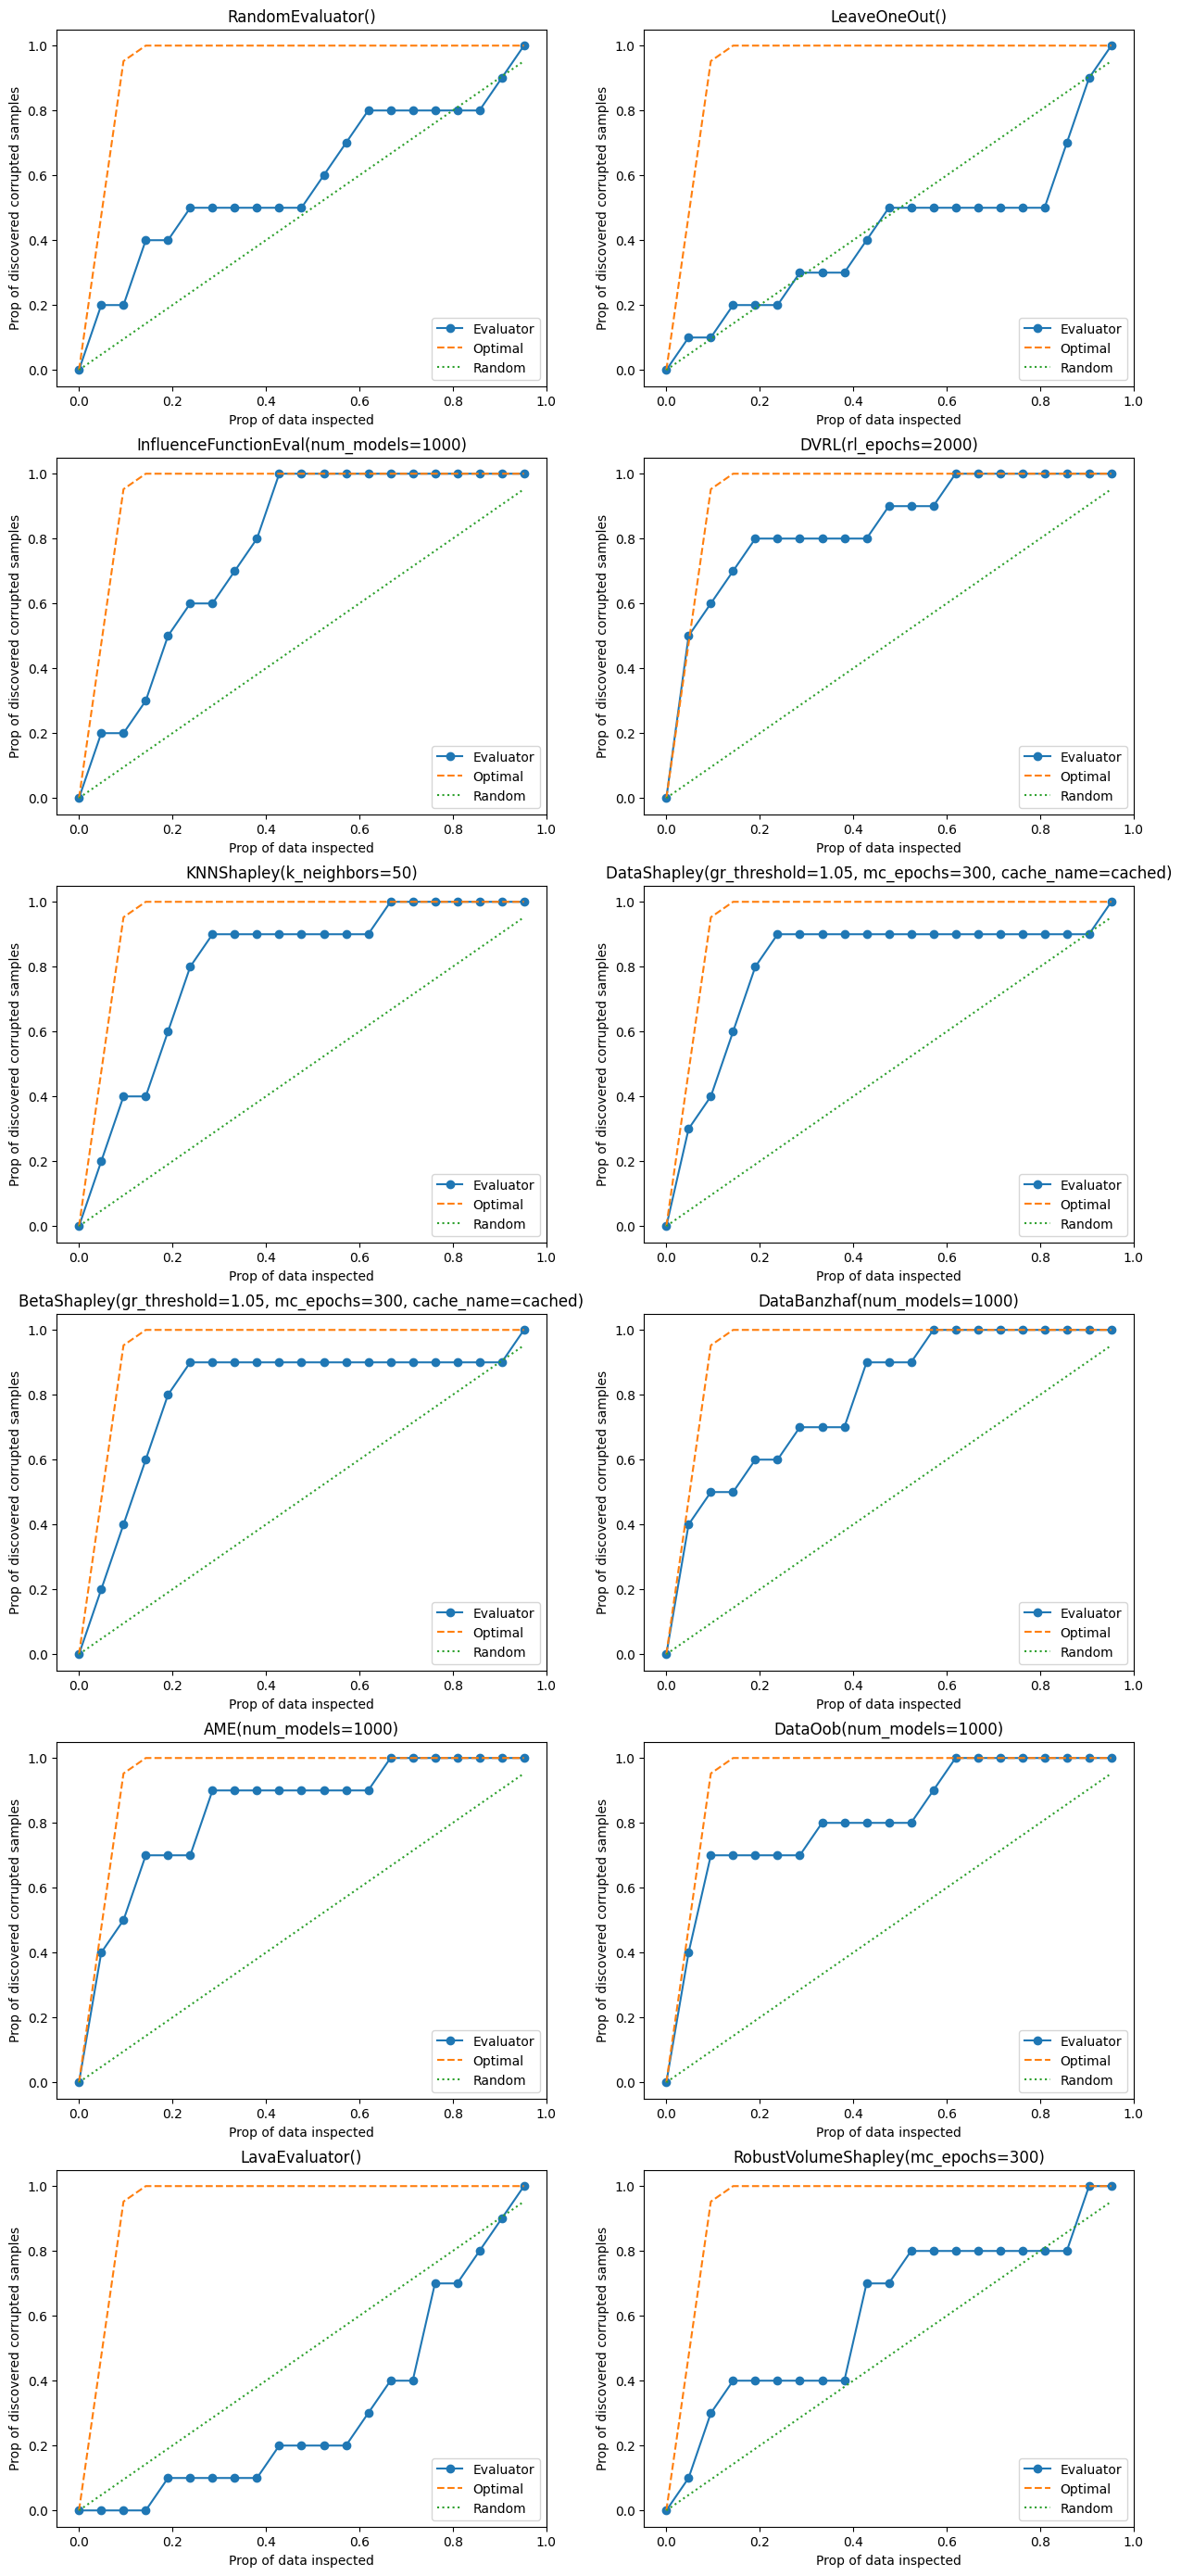

In [7]:
fig = plt.figure(figsize=(15, 35))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

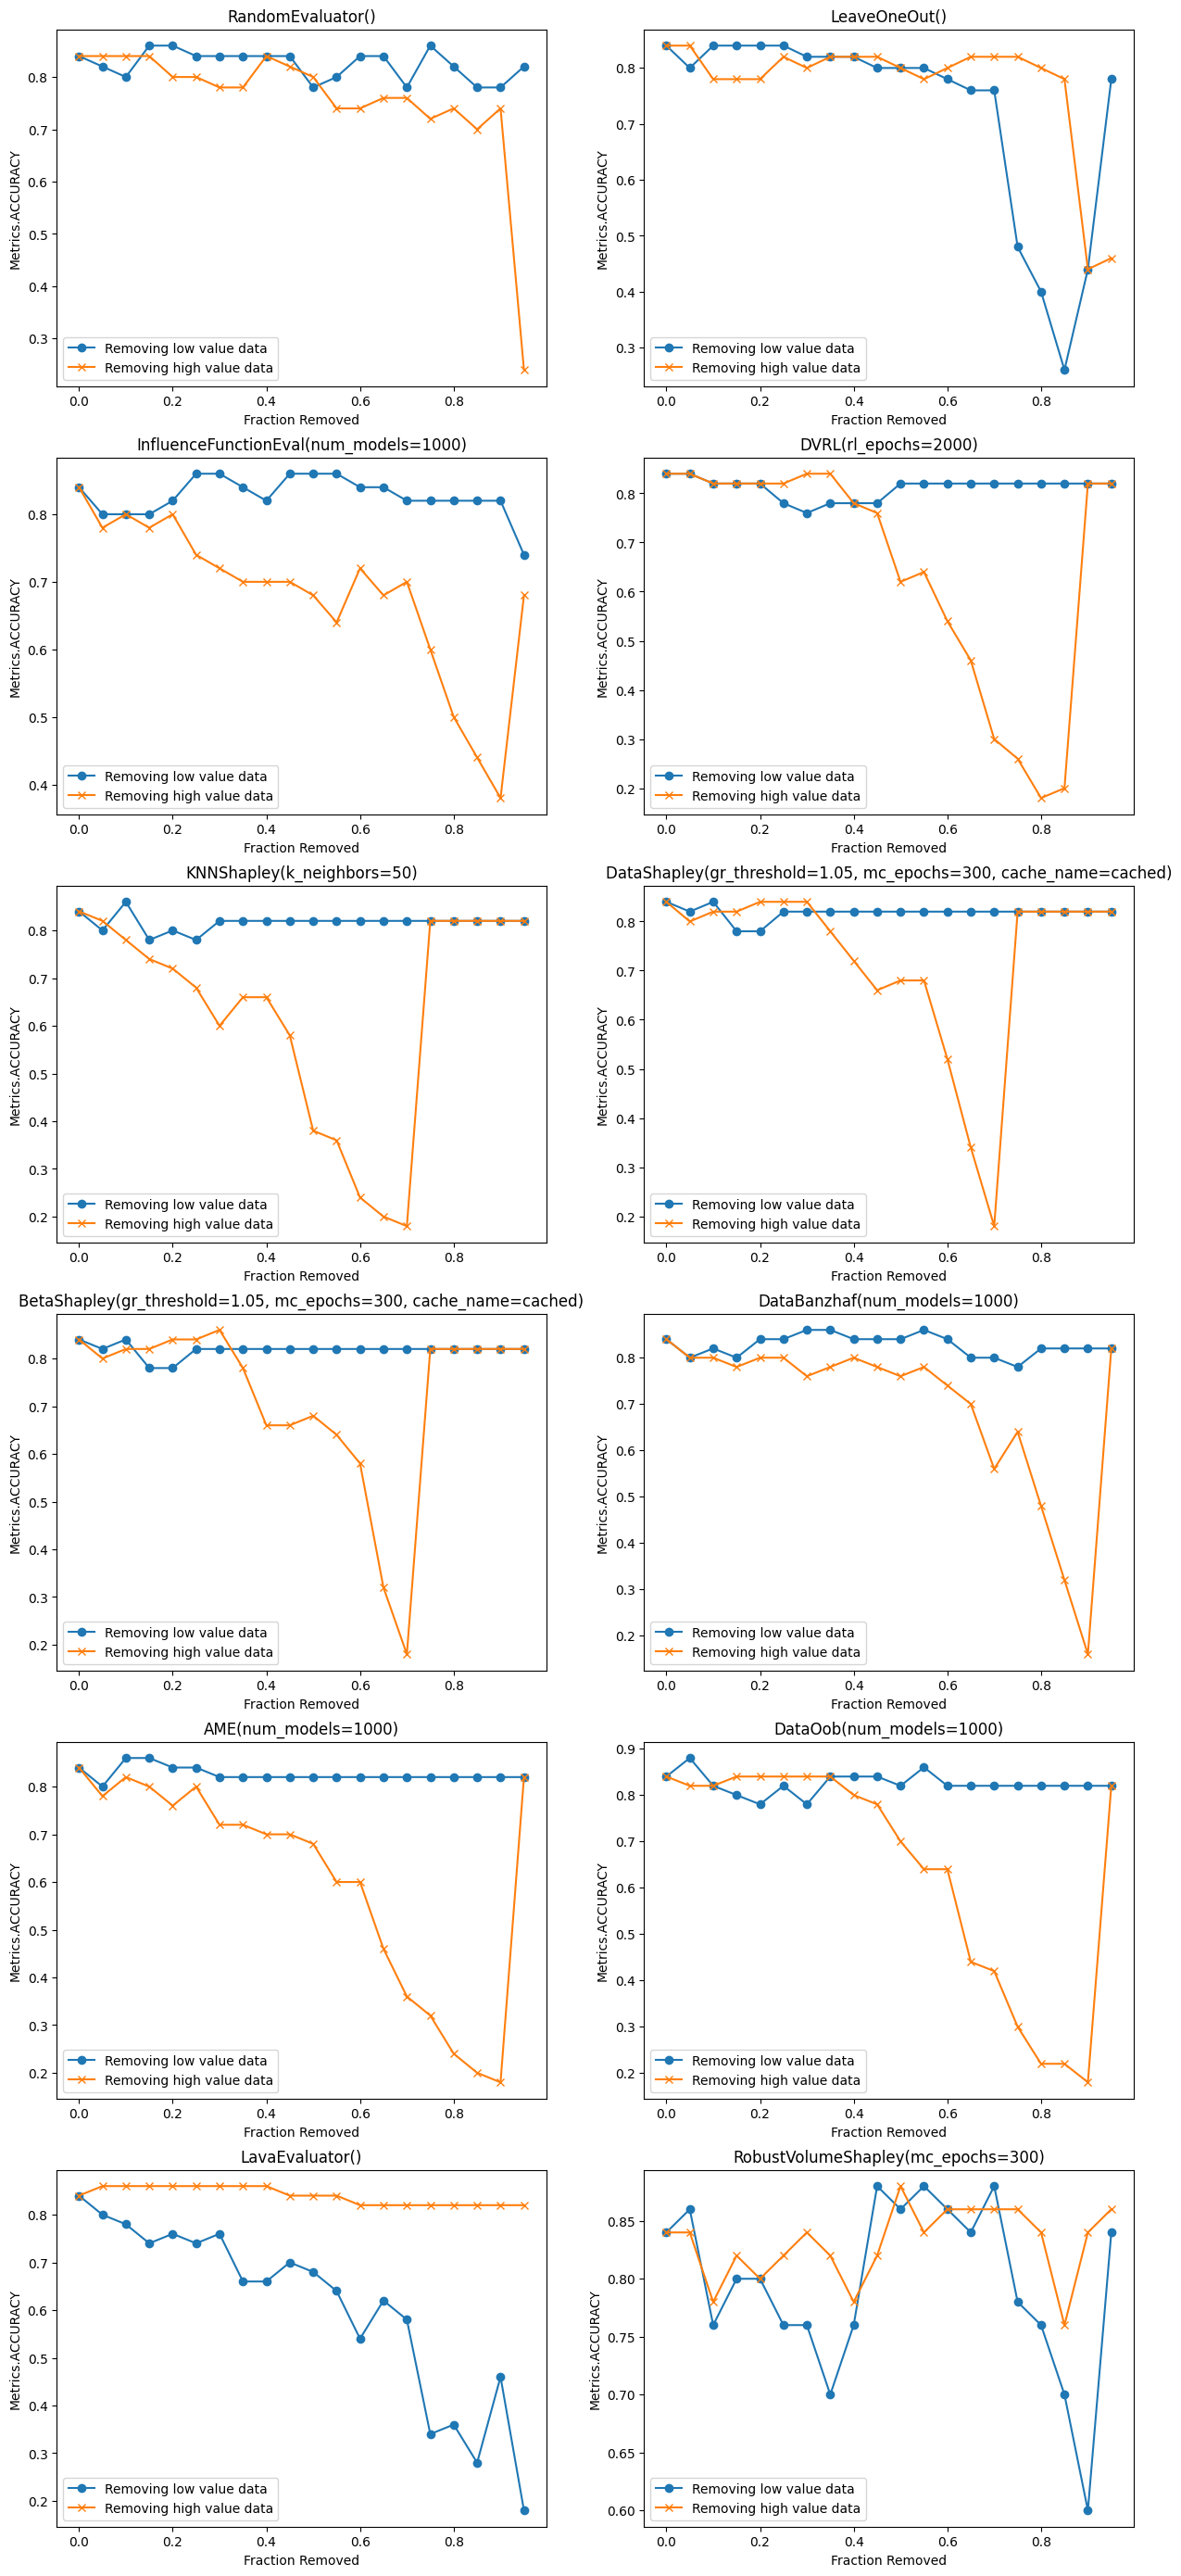

In [8]:
fig = plt.figure(figsize=(15, 35))
df_resp, fig = exper_med.plot(remove_high_low, fig, include_train=True, col=2, save_output=True)

In [9]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.ACCURACY,remove_most_influential_first_Metrics.ACCURACY,axis
RandomEvaluator(),0.84,0.84,0.0
RandomEvaluator(),0.82,0.84,0.05
RandomEvaluator(),0.8,0.84,0.1
RandomEvaluator(),0.86,0.84,0.15
RandomEvaluator(),0.86,0.8,0.2
...,...,...,...
RobustVolumeShapley(mc_epochs=300),0.78,0.86,0.75
RobustVolumeShapley(mc_epochs=300),0.76,0.84,0.8
RobustVolumeShapley(mc_epochs=300),0.7,0.76,0.85
RobustVolumeShapley(mc_epochs=300),0.6,0.84,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [10]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),26361,0.936531
RandomEvaluator(),12700,0.924494
RandomEvaluator(),5689,0.267018
RandomEvaluator(),37683,0.216486
RandomEvaluator(),40491,0.026909
...,...,...
RobustVolumeShapley(mc_epochs=300),36599,0.0
RobustVolumeShapley(mc_epochs=300),26439,0.0
RobustVolumeShapley(mc_epochs=300),16378,0.0
RobustVolumeShapley(mc_epochs=300),15273,0.0
